In [1]:
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import io
import torchvision.datasets as dsets
from torch.utils.data import (
    Dataset,
    DataLoader,
)  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Bangla Digit Recog/Dataset C.zip"

Streaming output truncated to the last 5000 lines.
  inflating: training-c/c19299.png   
  inflating: training-c/c19300.png   
  inflating: training-c/c19301.png   
  inflating: training-c/c19302.png   
  inflating: training-c/c19303.png   
  inflating: training-c/c19304.png   
  inflating: training-c/c19305.png   
  inflating: training-c/c19306.png   
  inflating: training-c/c19307.png   
  inflating: training-c/c19308.png   
  inflating: training-c/c19309.png   
  inflating: training-c/c19310.png   
  inflating: training-c/c19311.png   
  inflating: training-c/c19312.png   
  inflating: training-c/c19313.png   
  inflating: training-c/c19314.png   
  inflating: training-c/c19315.png   
  inflating: training-c/c19316.png   
  inflating: training-c/c19317.png   
  inflating: training-c/c19318.png   
  inflating: training-c/c19319.png   
  inflating: training-c/c19320.png   
  inflating: training-c/c19321.png   
  inflating: training-c/c19322.png   
  inflating: training-c/c19323.png   

In [4]:
class BanglaDigitDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 3]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [5]:
data = BanglaDigitDataset("/content/training-c.csv","/content/training-c", transforms.Compose([transforms.ToPILImage(), transforms.Resize(size=(28, 28)), transforms.ToTensor()]))
train_set, test_set = torch.utils.data.random_split(data,[19438,4860])

In [6]:
# train_set[0][0].size()
data.__len__()

24298

In [7]:
# Hyperparameters
batch_size = 20
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 6
output_dim = 10

learning_rate = 0.01
loss_lst = []
acc_lst = []

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, 200)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(200, 200)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(200, 200)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(200, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        # x = x.view(x.shape[0], -1)
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)


# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            loss_lst.append(loss.item())
            acc_lst.append(accuracy)
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.308216094970703. Accuracy: 10.555555555555555
Iteration: 1000. Loss: 2.308976650238037. Accuracy: 10.0
Iteration: 1500. Loss: 2.3132591247558594. Accuracy: 9.938271604938272
Iteration: 2000. Loss: 2.3029093742370605. Accuracy: 10.555555555555555
Iteration: 2500. Loss: 2.2884345054626465. Accuracy: 10.123456790123457
Iteration: 3000. Loss: 2.3094189167022705. Accuracy: 9.91769547325103
Iteration: 3500. Loss: 2.3134219646453857. Accuracy: 10.555555555555555
Iteration: 4000. Loss: 2.3312630653381348. Accuracy: 9.362139917695472
Iteration: 4500. Loss: 2.3137404918670654. Accuracy: 10.267489711934155
Iteration: 5000. Loss: 2.321038007736206. Accuracy: 9.938271604938272
Iteration: 5500. Loss: 2.3009512424468994. Accuracy: 9.938271604938272
Iteration: 6000. Loss: 2.3169760704040527. Accuracy: 9.465020576131687
Iteration: 6500. Loss: 2.297314167022705. Accuracy: 9.938271604938272
Iteration: 7000. Loss: 2.3084068298339844. Accuracy: 9.362139917695472
Iteration: 7500. Los

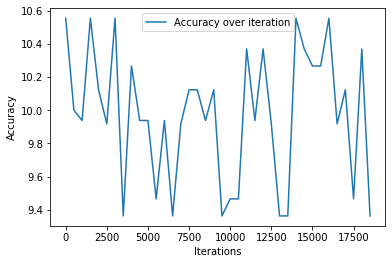

In [9]:
n_itr = np.arange(1,19000,500,int).tolist()
# len(n_itr)
plt.plot(n_itr,acc_lst,'-',label='Accuracy over iteration');
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

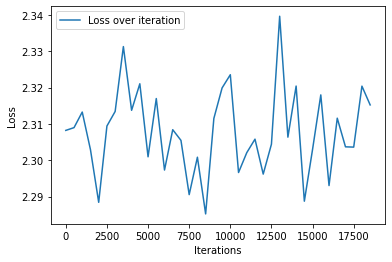

In [10]:
plt.plot(n_itr,loss_lst,'-',label='Loss over iteration');
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()